# Traffic Sign Recognition using a CNN

### Classification
One of the most common use case when doing image recognition is what we call classification. Basically, when presented with a picture, the algorithm should be able to tell what the picture represent, give it one (or several) **label**.

### Traffic Sign Recognition
One subclass of problem is the recognition of traffic signs on the roads. I do not have to explain that this has been (and still is) a very important research topic (see the self-driving car )

<img src="https://www.seton.net.au/media/catalog/product/cache/1/small_image/280x280/9df78eab33525d08d6e5fb8d27136e95/a/3/a34046.jpg" width="200">

Using a convolutional neural network, I'll try here to first train a network to detect if the picture represent a traffic sign or not, and then identify which type of sign t is.

### Setup
I am using this data for this [Reference Data](http://parse.ele.tue.nl/research/speedsign/) from the university of Eindhoven in the Netherlands as it is already processed to a nice format (save us some time in image processing), and the dataset is relatively small (which suits my not all too powerfull GPU ... more about that below).

We'll be using [TensorFlow](https://www.tensorflow.org/) on a GPU as back-end (NVidia with [CUDA/cuDNN](https://developer.nvidia.com/cuda-downloads) support, unfortunately only 2GB of RAM) and [Keras](https://keras.io/) on top of it to simplify the wiring. I'll leave it to the reader to install all of this. While the installation process has been getting better over the years, it is still cumbersone enough that it would take a whole notebook just to explain it!

## Loading the libraries

In [1]:
## Loading the libraries
import numpy
import scipy.io as sio
from scipy import misc
from scipy.misc import toimage
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from random import seed
from random import randint

from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

Using TensorFlow backend.


Checking that the GPU is enabled. In the jupyter standard output log, the following line indicates that the GPU has correctly been found and identified.

```
I c:\tf_jenkins\home\workspace\release-win\device\gpu\os\windows\tensorflow\core\common_runtime\gpu\gpu_device.cc:885] Found device 0 with properties:
name: Quadro K2100M
major: 3 minor: 0 memoryClockRate (GHz) 0.6665
pciBusID 0000:01:00.0
Total memory: 2.00GiB
Free memory: 1.66GiB
```

# Load the matlab dataset

In [2]:
data = sio.loadmat("speedsigndataset.mat")

# Split in train and test data
X_train_raw = data["trainset"] 
y_train_raw = data["classtrainset"] 
X_test_raw = data["testset"] 
y_test_raw = data["classtestset"] 

### What's the shape of the data set

In [3]:
X_train_raw.shape

(32, 32, 3100)

The shape will need to be changed to fit the model

## What's in the dataset

The training data is made of b&w pictures (32 x 32 pixels), let's have a look to get a feeling of the content of the dataset. Always a good starting point when working with pictures.

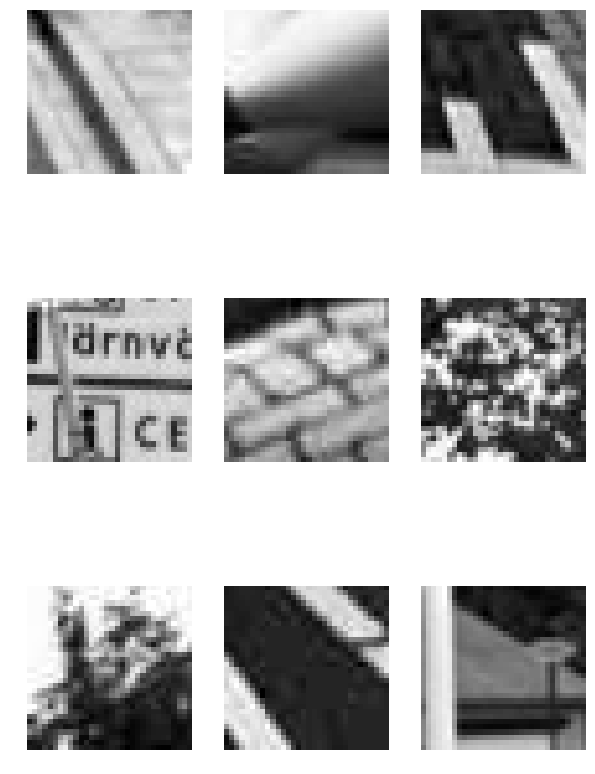

In [4]:
X_train_photo = numpy.rollaxis(X_train_raw,2,0)

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(toimage(X_train_photo[i]), cmap=plt.cm.gray)
plt.show()


There are 2 labelling schemes in the label array as described in the table below (column output label). We are interesting only in the first one here, whether a picture is a traffic sign or not.(it would be easy to train a model to actually identify the speed limits)


![alt text](dataTable.png "Labels structure")


## Format the dataset to match the requested CNN input format

In [5]:
# roll the axes to have the row length being the first parameter
X_train_rolled = numpy.rollaxis(X_train_raw,2,0)

# CNN accepts tensors of dimension 4 as input, so we need to add an extra dimension
X_train = X_train_rolled.reshape(X_train_rolled.shape + (1,)).astype('float32') / 255

# do the same for the test set
X_test_rolled = numpy.rollaxis(X_test_raw,2,0)
X_test = X_test_rolled.reshape(X_test_rolled.shape + (1,)).astype('float32') / 255


print("Shape of X_train: {0}, Shape of X_test: {1} ".format(X_train.shape, X_test.shape) )

Shape of X_train: (3100, 32, 32, 1), Shape of X_test: (517, 32, 32, 1) 


Images are here already normalized between 0 and 1. When using RGB pictures for example, first normalizing them might improve the performance of the neural network.

### And now the labels

We are only interested in the first columns

In [6]:
y_train_rolled = numpy.rollaxis(y_train_raw, 1, 0)
y_test_rolled = numpy.rollaxis(y_test_raw, 1, 0)

# Here the classes scheme is changed in a categorical scheme. 2 columns representing the 0 and 1, 
# a 1 is present when the column is selected, otherwise a 0.
y_train = np_utils.to_categorical(y_train_rolled[:,0:1])
y_test = np_utils.to_categorical(y_test_rolled[:,0:1])
num_classes = y_test.shape[1]

print("Shape of y_train: {0}, Shape of y_test: {1}, number of classes {2} ".format(y_train.shape, y_test.shape, num_classes ))

Shape of y_train: (3100, 2), Shape of y_test: (517, 2), number of classes 2 


# Binary Classification with a Convolutional Neural Network

### Define the network

The model is a simple model with 2 convolutional layers and 2 dense layers, the first 3 have a relu activation and the latest a softmax.
Dropout and Maxpooling are applied to improve the overall performance of the network.


In [7]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 1), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

### Train the network

In [8]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3100 samples, validate on 517 samples
Epoch 1/25
3100/3100 [==============================] - 6s - loss: 0.4175 - acc: 0.8303 - val_loss: 0.2156 - val_acc: 0.9246
Epoch 2/25
3100/3100 [==============================] - 5s - loss: 0.1501 - acc: 0.9458 - val_loss: 0.1203 - val_acc: 0.9458
Epoch 3/25
3100/3100 [==============================] - 5s - loss: 0.1058 - acc: 0.9632 - val_loss: 0.0951 - val_acc: 0.9632
Epoch 4/25
3100/3100 [==============================] - 5s - loss: 0.0663 - acc: 0.9752 - val_loss: 0.0552 - val_acc: 0.9845
Epoch 5/25
3100/3100 [==============================] - 5s - loss: 0.0517 - acc: 0.9826 - val_loss: 0.0414 - val_acc: 0.9865
Epoch 6/25
3100/3100 [==============================] - 5s - loss: 0.0422 - acc: 0.9868 - val_loss: 0.0496 - val_acc: 0.9807
Epoch 7/25
3100/3100 [==============================] - 5s - loss: 0.0298 - acc: 0.9910 - val_loss: 0.0388 - val_acc: 0.9845
Epoch 8/25
3100/3100 [==============================] - 5s - loss: 0.0314 - ac

**This went well !!**

To summarize: 
* \> 4 millions parameters to train on !!
* 5s per epoch (this is where the GPU comes in handy :0))

Accuracy **99.42%** is quite impressive, of 3000 pictures it gets on average a bit more than 1 picture wrong!

Actually, if you look carefully in the results list, we even got to 99.81%, more on this later. 


The network has been trained and is now saved into a file so we don't have to retrain it everytime we want to use.

In [9]:
# now we save the model, so we don't have to do the training all over again
model.save('eindhoven-model.h5')

In [10]:
# loading the weights if we don't want to retrain the model
model.load_weights('eindhoven-model.h5')

Let's just get a quick look in the data to get a feeling of what the algorithm is doing.

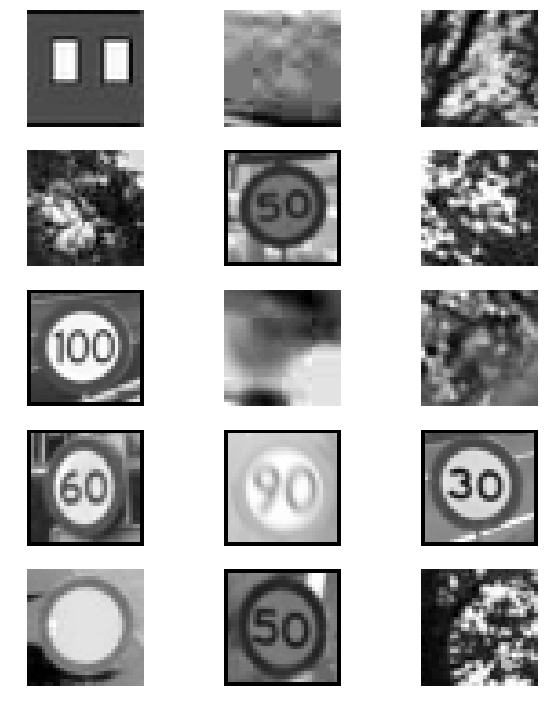

In [11]:
seed(1241251) # so we always get the same number

# parameters for image display
numcols = 3
numrows = 6

# we start at index 90, and show the next 15 pictures
pictureCount = 15;

prediction = model.predict(X_test)

for i in range(0,pictureCount):
    
    index = randint(0, len(X_test)) 
    
    image = np.copy(X_test[index].reshape(32,32)) * 255
    
    # if prediction is 1, add a black border to the picture
    
    if prediction[index][1] > 0.5:
        image[0:1] = 0
        image[:,0] = 0
        image[:,31] = 0
        image[31,:] = 0
    
    
    plt.subplot(6, 3, 1 + i) # nrows, ncols, plot_number
    plt.axis('off')
    plt.imshow(toimage(image), cmap=plt.cm.gray)
plt.show()

Looking nice right :-) 

## Multi-class classifier using a CNN

Now that we managed to separate traffic signs from non traffic signs, let's see if we can identify the sign themselves.

A multi-class CNN is not much different from a Binary CNN, instead of having 2 output neurons, it has as many as there are classes.

### Format the labels

The labels for the specific boards are already arranged categorically (See table 1)
The labels for the background pictures are defined as the absence of labelling (all values to 0). We need to introduce a specific label for the absence of label (as the absence of a class is a class in itself!) 

In [12]:
def categoriseBackgroundValue(array):
    resultArray = []
    for value in array:
        # make a local copy in order to to mess with the original data
        localValue = np.copy(value)
        if(np.sum(localValue[0]) == 0): # only when all the labels are 0 can we concluse that this is a background picture
            localValue[0] = 1
        else:
            localValue[0] = 0 
        resultArray.append(localValue)
    return np.array(resultArray)
    
y_train = categoriseBackgroundValue(y_train_rolled)
y_test = categoriseBackgroundValue(y_test_rolled)
num_classes = y_test.shape[1]

print("Shape of y_train: {0}, Shape of y_test: {1}, number of classes {2} ".format(y_train.shape, y_test.shape, num_classes ))

Shape of y_train: (3100, 8), Shape of y_test: (517, 8), number of classes 8 


Let's visualize pictures to see that the encoding has been successfull

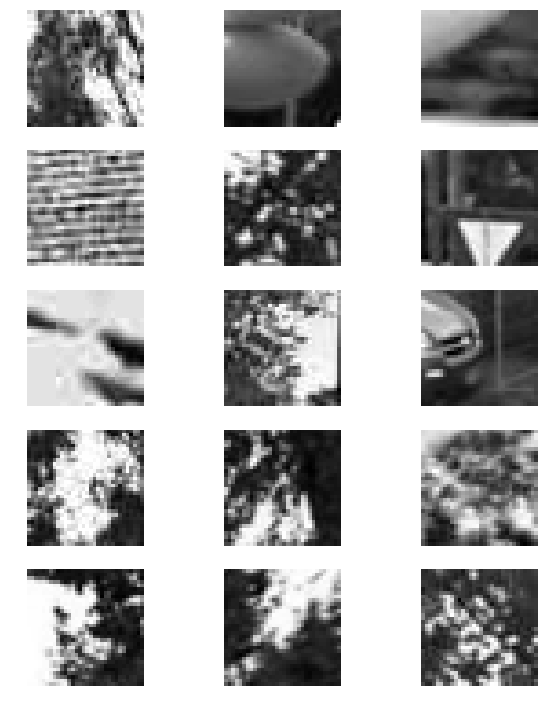

In [13]:
# parameters for image display
numcols = 3
numrows = 6


# change the picture index to display pictures with a different label
pictureIndex = 0
'''
0 -> background
1 -> 30
2 -> 50
3 -> 60
4 -> 70
5 -> 80
6 -> 90
7 -> 100
'''
pictureCount = 0
for i in range(0,len(X_test)):
    
    # if prediction is 1, add a black border to the picture
    
    if y_test[i][0] == 1:
        image = np.copy(X_test[i].reshape(32,32)) * 255
    
    
        plt.subplot(6, 3, 1 + pictureCount) # nrows, ncols, plot_number
        plt.axis('off')
        plt.imshow(toimage(image), cmap=plt.cm.gray)
        pictureCount = pictureCount+1
        
    if pictureCount == 15:
        break
plt.show()

# Train the model

Now we'll create a slighly improved model, as the task is a little more demanding. We doubled the number of parameters to ~8.4 millions!

In [14]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 1), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 200
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 8200      
Total para

#### Training

Let's improve the training process by introducing a few "callbacks" that allow for a finer control of the training process:
* Checkpoints, that will keep track of the best model
* Reducing LR on plateau, that will reduce the learning rate if the model gets stranded
* EarlyStopping, we'll stop if the model is not progressing at all for a certain amount of time

In [15]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

filepath="weights.eindhoven-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#reduce the learning rate if the training is not going as well as expected
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001, verbose = 1)

# stop when no improvement is registered
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

callbacks_list = [checkpoint, reduce_lr, earlyStopping]

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,callbacks=callbacks_list, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3100 samples, validate on 517 samples
Epoch 1/200
3100/3100 [==============================] - 8s - loss: 0.9597 - acc: 0.7926 - val_loss: 0.8472 - val_acc: 0.8027
Epoch 2/200
3100/3100 [==============================] - 8s - loss: 0.6628 - acc: 0.8129 - val_loss: 0.4973 - val_acc: 0.8395
Epoch 3/200
3100/3100 [==============================] - 8s - loss: 0.4128 - acc: 0.8616 - val_loss: 0.3168 - val_acc: 0.9052
Epoch 4/200
3100/3100 [==============================] - 8s - loss: 0.2660 - acc: 0.9187 - val_loss: 0.2239 - val_acc: 0.9381
Epoch 5/200
3100/3100 [==============================] - 8s - loss: 0.1458 - acc: 0.9535 - val_loss: 0.1099 - val_acc: 0.9691
Epoch 6/200
3100/3100 [==============================] - 8s - loss: 0.1028 - acc: 0.9703 - val_loss: 0.1042 - val_acc: 0.9749
Epoch 7/200
3100/3100 [==============================] - 8s - loss: 0.0571 - acc: 0.9842 - val_loss: 0.0974 - val_acc: 0.9710
Epoch 8/200
3100/3100 [==============================] - 8s - loss: 0.0

Accuracy of 99.23%, not bad at all!!

Let's have a look to see what this does on a random sample of images

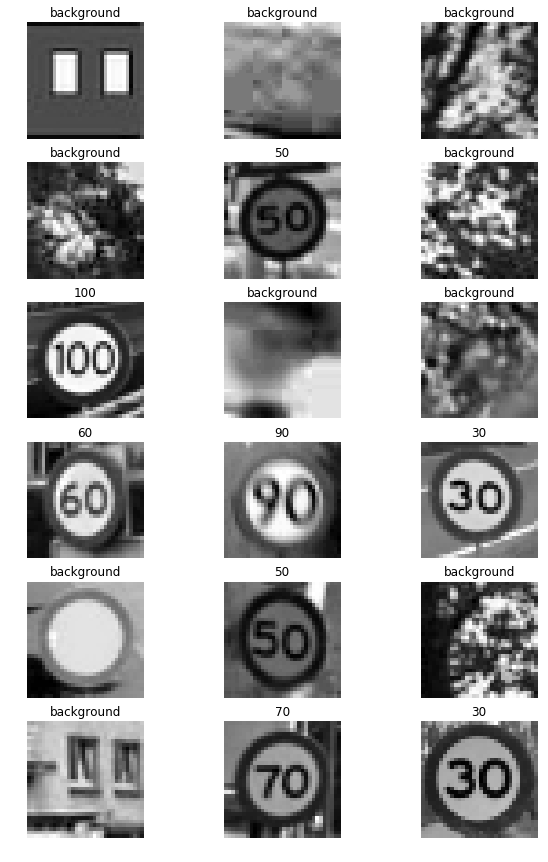

In [16]:
seed(1241251) # so we always get the same number

# parameters for image display
numcols = 3
numrows = 6

labels = ["background", "30", "50", "60", "70", "80", "90", "100"]


# we are going to pick 2 pictures randomly
pictureCount = numcols * numrows;

prediction = model.predict(X_test)

for i in range(0,pictureCount):
    
    index = randint(0, len(X_test)) 
    
    image = np.copy(X_test[index].reshape(32,32)) * 255
    
    # if prediction is 1, add a black border to the picture
    
    predictedLabel = np.argmax(prediction[index])
    
    
    plt.subplot(6, 3, 1 + i) # nrows, ncols, plot_number
    plt.axis('off')
    plt.title(labels[predictedLabel])
    plt.imshow(toimage(image), cmap=plt.cm.gray)
plt.show()

## What is the convnet doing?

Let's visualize what the first convnet layer is doing to some of the pictures (after the so-called activation)

In [17]:
# We build a new model with the activations of the old model first layer
# This model is truncated after the first layer. We load the weights of the old model, no training requested !

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(32, 32, 1), weights=model.layers[0].get_weights()
                 , padding='same', activation='relu', kernel_constraint=maxnorm(3)))

activations = model2.predict(X_test)

In [18]:
# utility for printing out the activation map of a picture
def printActivation(imageIndex):
    # parameters for image display
    numcols = 4
    numrows = 8
    
    weights = numpy.rollaxis(activations[imageIndex],2,0)
    
    for i in range(0,32):
        image = np.copy( weights[i])
        plt.subplot(8, 4, 1 + i) # nrows, ncols, plot_number
        plt.axis('off')
        plt.imshow(toimage(image), cmap=plt.cm.gray)

    plt.show()

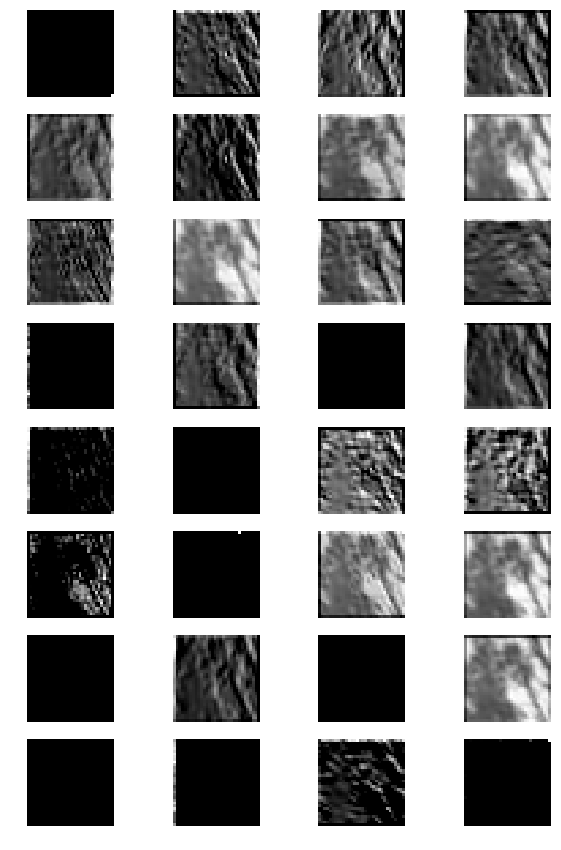

In [19]:
# print the activation for a background picture
printActivation(0) 

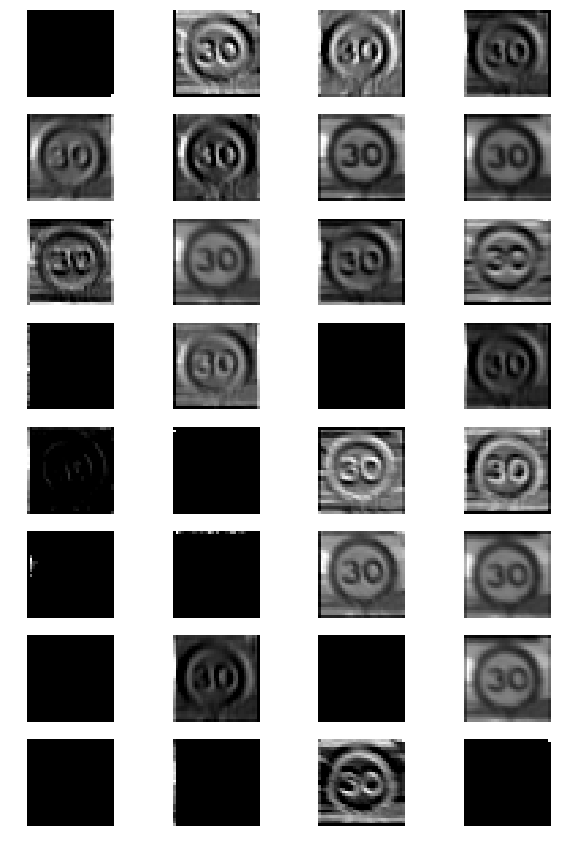

In [20]:
# print the activation for a 30 board
for i in range(0, len(y_test)):
    if(y_test[i][1]==1):
        idx = i
        break
        
printActivation(idx)

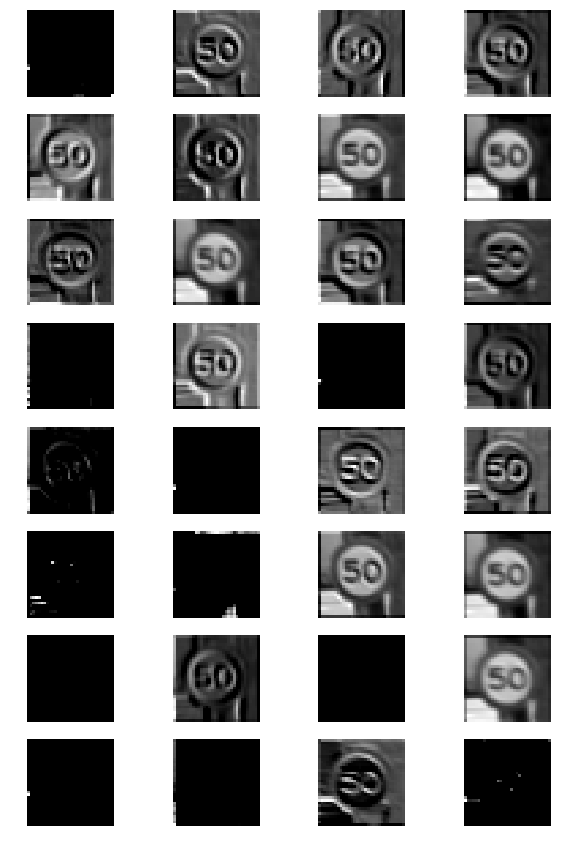

In [21]:
# print activation for 50 board
for i in range(0, len(y_test)):
    if(y_test[i][2]==1):
        idx = i
        break
        
printActivation(idx)

We can see that a few of the pictures are completely black. These do not contribute much to the network.

This means that our network might actually be too powerfull and that we could probably do away with a less deep network (but one using all the input filters)